This notebook tests the condition which is reflected in MDAnalysis.lib.distances.capped_distance function. Depending on the number of particles in reference and configuration state, the method is automatically chosen based on this notebook.

The primary variables are number of particle coordinates and the cutoff distance.

In [1]:
import MDAnalysis as mda
from MDAnalysis.lib.distances import capped_distance
import numpy as np

In [20]:
%matplotlib inline

In [2]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

First lets begin by checking whether both the methods implemented in `capped_distance` return correct and similar results. To reduce the complications, lets check the all the particles within a fixed radius of 4 distance units from each other in a orthogonal box.

In [3]:
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
Npoints = 1000
points = get_coords(box, Npoints)
max_dist = 4.

In [5]:
pair, dist = capped_distance(points, points, max_dist, box=box, method='bruteforce')

In [6]:
pair_kd, dist_kd = capped_distance(points, points, max_dist, box=box, method='pkdtree')

In [8]:
np.testing.assert_array_equal(pair, pair_kd)

In [10]:
np.testing.assert_array_equal(dist, dist_kd)

It must be noted that the performance of the brute force can be increased by calculating only half the distances rather than the currently implemented function, which calculates distances between all the pairs. However, it will reduce the flexibility of the function to find the capped distances between two arbitrary selections/ set of atoms.

In any case, lets use this use case to check the time consumption due to different number of particles and fixed cutoff distance

In [11]:
Npoints = np.logspace(2, 5, num=10, dtype=np.int)
max_dist = 4.0
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)

In [19]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    res = %timeit -q -o capped_distance(points, points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(points, points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    result['N'].append(N)

In [15]:
import matplotlib
import matplotlib.pyplot as plt

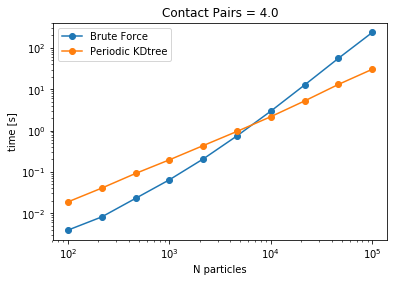

In [21]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

Lets check the variation of the cutoff radius for the extremities of number of particles tested above.

In [22]:
max_dist = np.linspace(1, 15, num=15, dtype=np.float)
Npoints = np.logspace(2, 5, num=3, dtype=np.int)
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)

In [ ]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    for cut in tqdm_notebook(np.unique(max_dist)):
    
        res = %timeit -q -o capped_distance(points, points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(N)].append(res.average)
    
        res = %timeit -q -o capped_distance(points, points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(N)].append(res.average)
    
        if N == Npoints[0]:
            result['cut'].append(cut)

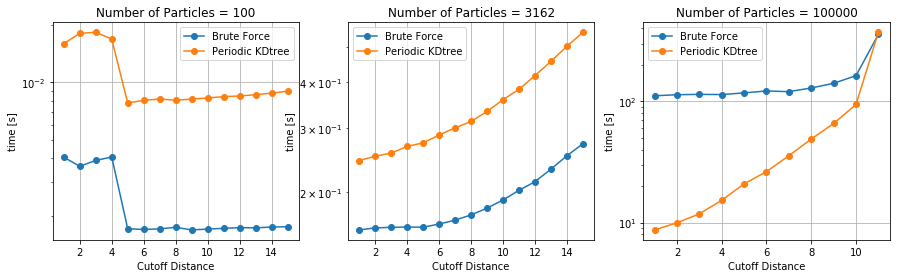

In [37]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols-1):
    ax = axes[i]
    ax.plot(result['cut'], result['bf'+'.'+str(Npoints[i])], 'o-', label='Brute Force')
    ax.plot(result['cut'], result['pkdtree'+'.'+str(Npoints[i])], 'o-', label='Periodic KDtree')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(Npoints[i]))
    ax.legend()
    ax.grid(True)
ax = axes[2]
ax.plot(result['cut'][:-4], result['bf'+'.'+str(Npoints[2])][:-1], 'o-', label='Brute Force')
ax.plot(result['cut'][:-4], result['pkdtree'+'.'+str(Npoints[2])], 'o-', label='Periodic KDtree')

ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(Npoints[2]))
ax.legend()
ax.grid(True)
#fig.tight_layout()


For large number of particles and large cutoff distances i.e. approximately greater than 10% of the box size will lead to increased time consumption for the case of KDtree.  

Till now the number of particles in reference and configuration state were same. Lets see another case where reference has only one query point and different than the configuration state.

In [42]:
Npoints = np.logspace(2, 5, num=10, dtype=np.int)
max_dist = 4.0
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
query = box[:3]/2

In [43]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    res = %timeit -q -o capped_distance(query, points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(query, points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    result['N'].append(N)

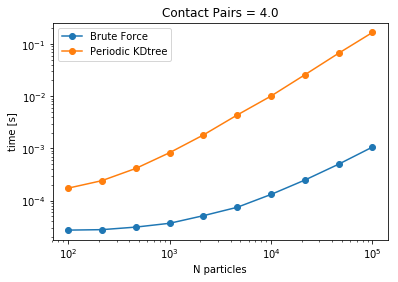

In [44]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

The execution time is dependent on the number of particles in each state. It is also necessary to check if there is any unintended behaviour for large cutoff radius.

In [38]:
Npoints = np.logspace(2, 5, num=3, dtype=np.int)
max_dist = np.linspace(1, 15, num=15, dtype=np.float)
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
query = box[:3]/2

In [39]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    for cut in tqdm_notebook(np.unique(max_dist)):
    
        res = %timeit -q -o capped_distance(query, points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(N)].append(res.average)
    
        res = %timeit -q -o capped_distance(query, points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(N)].append(res.average)
    
        if N == Npoints[0]:
            result['cut'].append(cut)

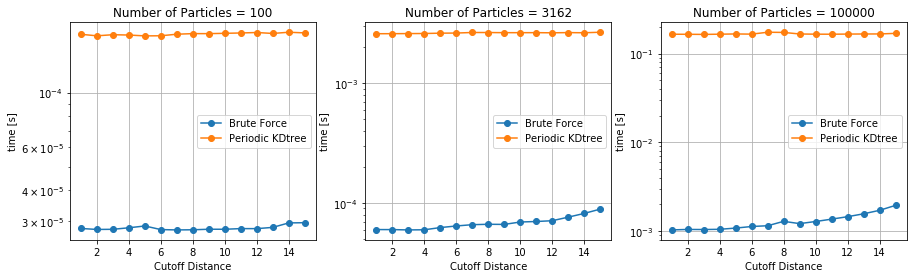

In [40]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols):
    ax = axes[i]
    ax.plot(result['cut'], result['bf'+'.'+str(Npoints[i])], 'o-', label='Brute Force')
    ax.plot(result['cut'], result['pkdtree'+'.'+str(Npoints[i])], 'o-', label='Periodic KDtree')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(Npoints[i]))
    ax.legend()
    ax.grid(True)
#fig.tight_layout()